In [1]:
import scipy
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import scipy.stats as stats
from scipy.stats import norm
import scipy.io as io
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from math import sqrt
from sklearn.metrics import r2_score

from sklearn.preprocessing import scale, StandardScaler
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from numpy import linalg
import itertools
from itertools import combinations

%matplotlib inline
plt.style.use('seaborn-white')


In [2]:
smoothed_df = pd.read_csv('smoothed_df.csv')

In [3]:
uncorrellated_features=[
    'FEED_D154', 'FEED_DS_010', 'FEED_DS_030', 'FEED_DS_070',
       'FEED_DS_090', 'DIESEL_DS_005', 'DIESEL_DS_010', 'DIESEL_DS_030',
       'DIESEL_DS_090', 'FEED_SULFUR', 'FEED_NITROGEN', 'FEED_KWATSON',
       'PROCESS_T_WABT', 'X370PLUS', 'PROCESS_PP_H2_OUT' ]

In [4]:

X = smoothed_df[uncorrellated_features]
y = smoothed_df['actual.values']

In [5]:
## Train test s
from sklearn.model_selection import train_test_split
## Train test split follows this distinguished code pattern and helps creating train and test set to build machine learning. 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .30, random_state = 0, shuffle=True, stratify=smoothed_df['PLANT_NAME'])

## Construction des modéles sur les données nettoyées

In [6]:
from sklearn.metrics import fbeta_score, make_scorer

# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)


## Linear regression

RMSE on Training set : 0.02909150852943799
RMSE on Test set : 0.02926279129681027


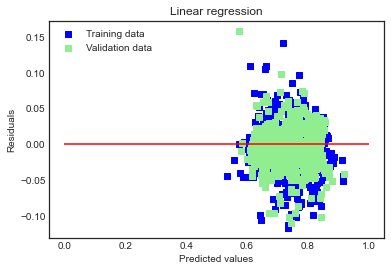

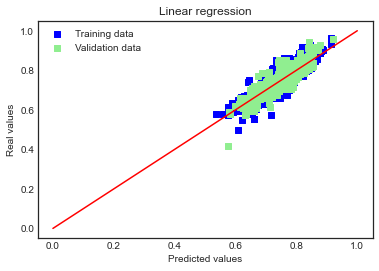

In [7]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())

y_trainpred = lr.predict(X_train)
y_testpred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_trainpred, y_trainpred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_testpred, y_testpred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 0, xmax = 1, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_trainpred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_testpred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 1], [0, 1], c = "red")
plt.show()

 ## Régression  RIDGE 

Best alpha : 0.01
Try again for more precision with alphas centered around 0.01
Best alpha : 0.006
Ridge RMSE on Training set : 0.029073978019209794
Ridge RMSE on Test set : 0.029171360236267662


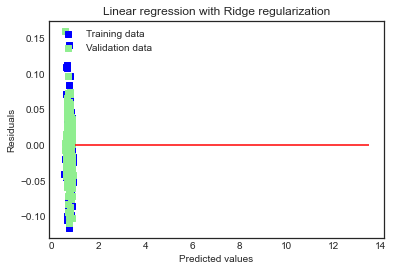

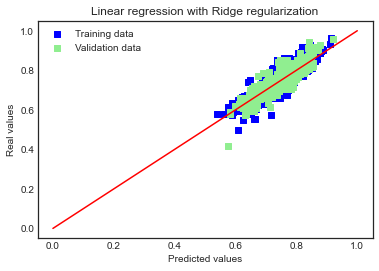

Ridge picked 15 features and eliminated the other 0 features


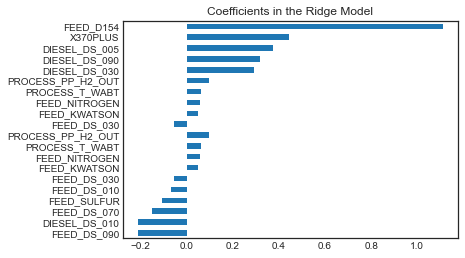

In [8]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())

y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 1, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 1], [0, 1], c = "red")
plt.show()
# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

## Régression LASSO

Best alpha : 0.0001
Try again for more precision with alphas centered around 0.0001
Best alpha : 6e-05
Lasso RMSE on Training set : 0.03002145278582804
Lasso RMSE on Test set : 0.02955271756238668


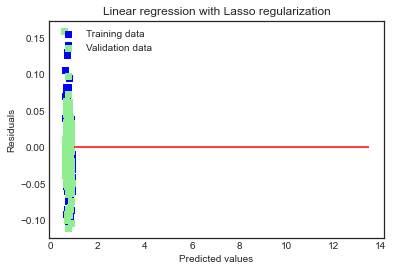

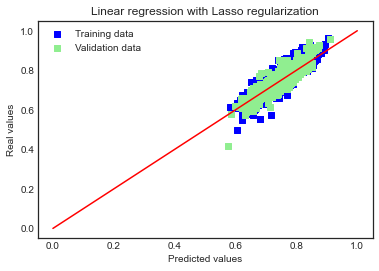

Lasso picked 12 features and eliminated the other 3 features


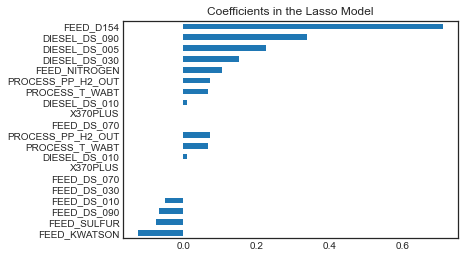

In [9]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())

y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 1, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 1], [0, 1], c = "red")
plt.show()
# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

## regularization ElasticNet 

Best l1_ratio : 0.1
Best alpha : 0.0001
Try again for more precision with l1_ratio centered around 0.1
Best l1_ratio : 0.085
Best alpha : 0.0001
Now try again for more precision on alpha, with l1_ratio fixed at 0.085 and alpha centered around 0.0001
Best l1_ratio : 0.085
Best alpha : 6e-05
ElasticNet RMSE on Training set : 0.029420103778119034
ElasticNet RMSE on Test set : 0.02922990693780943


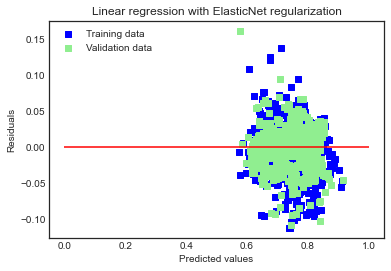

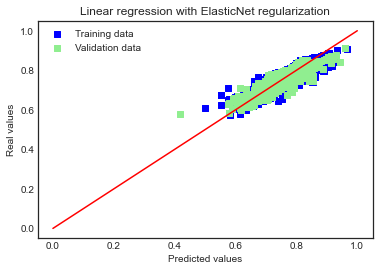

ElasticNet picked 15 features and eliminated the other 0 features


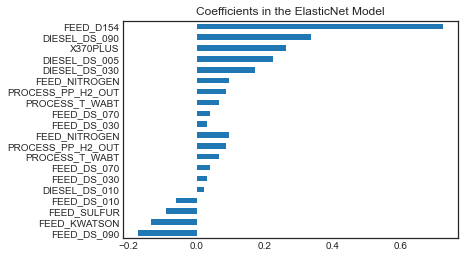

In [10]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1  
    alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )
print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())

y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 0, xmax = 1, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 1], [0, 1], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

In [11]:
UniqueSites = smoothed_df['PLANT_NAME'].unique()
DataFrameDict = {elem : pd.DataFrame for elem in UniqueSites}

for key in DataFrameDict.keys():
    DataFrameDict[key] = smoothed_df[:][smoothed_df['PLANT_NAME'] == key]


In [12]:
from sklearn.metrics import mean_squared_error



Site : 1
RMSE on Training set : 0.010095194554984829
RMSE on Test set : 0.01510814159130764


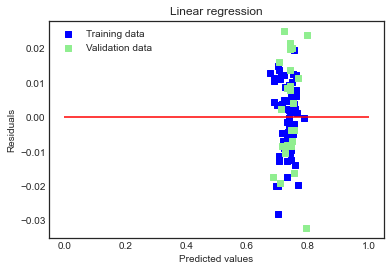

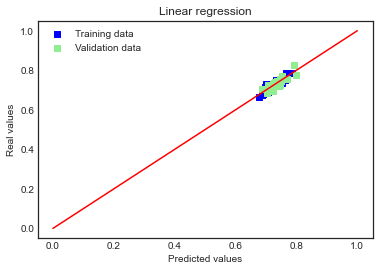

**************************************************
**************************************************
Site : 3
RMSE on Training set : 0.011021637157574878
RMSE on Test set : 0.01757926896103898


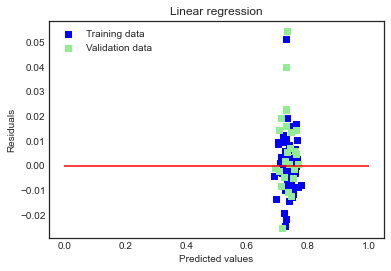

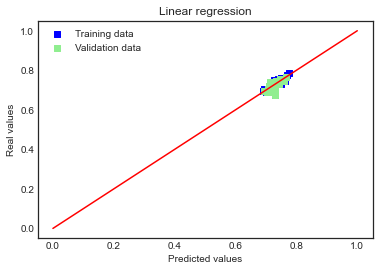

**************************************************
**************************************************
Site : 4
RMSE on Training set : 0.016395511829111087
RMSE on Test set : 0.019611149652817128


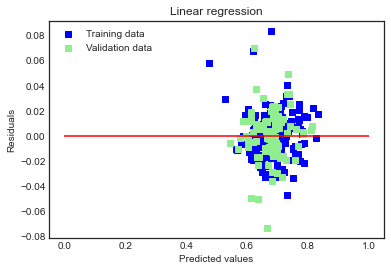

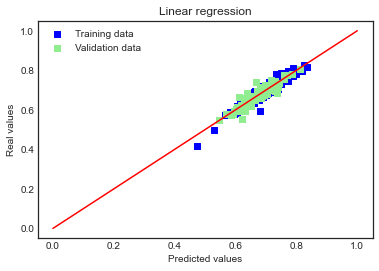

**************************************************
**************************************************
Site : 10
RMSE on Training set : 0.015550569727789105
RMSE on Test set : 0.019707625438310252


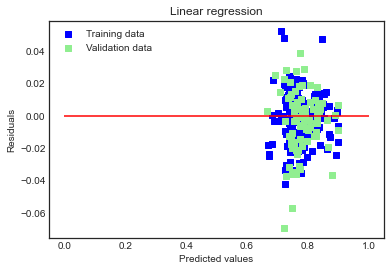

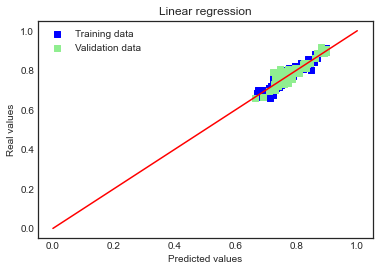

**************************************************
**************************************************
Site : 12
RMSE on Training set : 0.0063965226527767545
RMSE on Test set : 0.006221120790668805


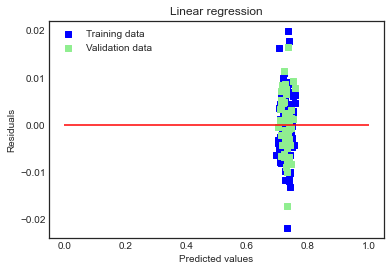

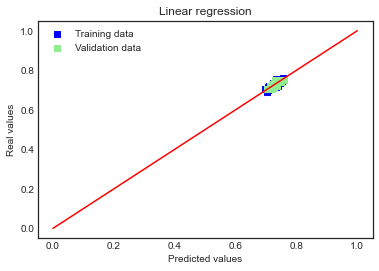

**************************************************
**************************************************
Site : 14
RMSE on Training set : 0.00835687784187425
RMSE on Test set : 0.009785854367206854


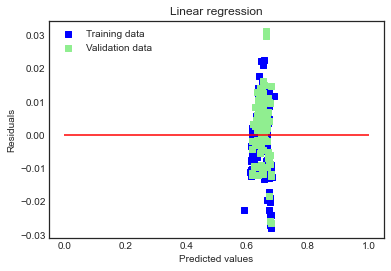

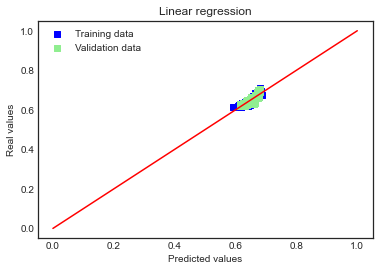

**************************************************
**************************************************
Site : 15
RMSE on Training set : 0.00965620064439019
RMSE on Test set : 0.011741638326285466


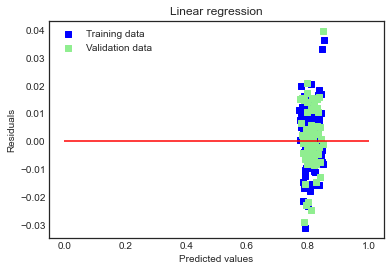

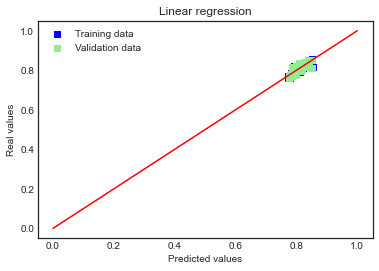

**************************************************
**************************************************
Site : 16
RMSE on Training set : 0.01091575440259109
RMSE on Test set : 0.017136295789048926


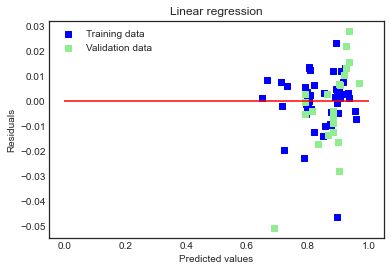

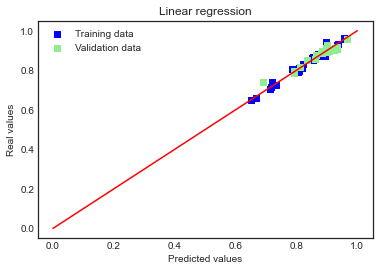

**************************************************
**************************************************
Site : 18
RMSE on Training set : 0.026887361414476486
RMSE on Test set : 0.030177081074378068


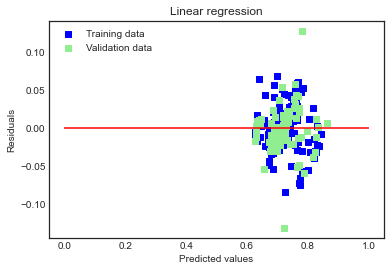

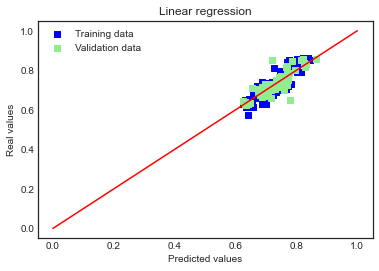

**************************************************
**************************************************
Site : 21
RMSE on Training set : 0.01091084445149943
RMSE on Test set : 0.014372557964646577


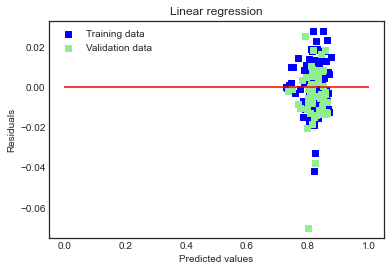

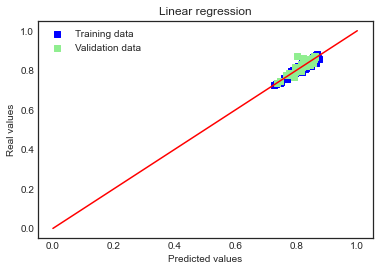

**************************************************
**************************************************


In [13]:
for site in np.sort(UniqueSites):
    dataframe__ = DataFrameDict[site]
    X__ = dataframe__[uncorrellated_features]
    y__ = dataframe__['actual.values']
    X_train__, X_test__, y_train__, y_test__ = train_test_split(X__, y__,test_size = .30, random_state = 0, shuffle=True)
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train__, y_train__)

   

    y_trainpred = lr.predict(X_train__)
    y_testpred = lr.predict(X_test__)

     # Look at predictions on training and validation set
    print("Site :", int(site))
    print("RMSE on Training set :", mean_squared_error(y_train__, y_trainpred, squared=False))
    print("RMSE on Test set :", mean_squared_error(y_test__, y_testpred, squared=False))
    
    # Plot residuals
    plt.scatter(y_trainpred, y_trainpred - y_train__, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_testpred, y_testpred - y_test__, c = "lightgreen", marker = "s", label = "Validation data")
    plt.title("Linear regression")
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.legend(loc = "upper left")
    plt.hlines(y = 0, xmin = 0, xmax = 1, color = "red")
    plt.show()

    # Plot predictions
    plt.scatter(y_trainpred, y_train__, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_testpred, y_test__, c = "lightgreen", marker = "s", label = "Validation data")
    plt.title("Linear regression")
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.plot([0, 1], [0, 1], c = "red")
    plt.show()
    print('*'*50)
    print('*'*50)

## Construction des modéles avec hyper paramétrage

## RIDGE

In [14]:
X_scaled = scale(X)


In [15]:
n_lambdas = 200
lambdas = np.logspace(5, -2, n_lambdas)

coefs = []
scores = []
for lam in lambdas:
    ridge = Ridge(alpha=lam)
    # it's very important to scale the data for Ridge regression
    ridge.fit(X_scaled, y)
    coefs.append(ridge.coef_)
    scores.append(ridge.score(X_scaled, y))

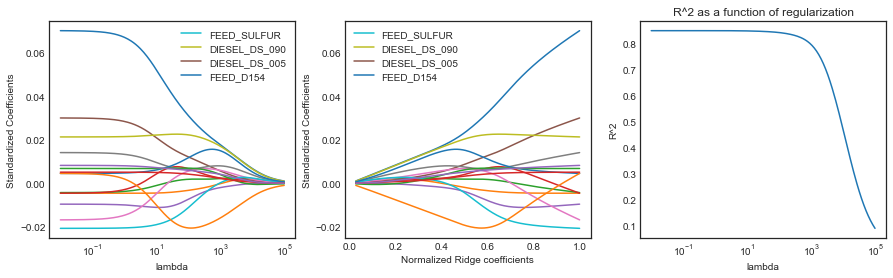

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

# get the four largest (in abs value) coefficient positions
ind = np.argpartition(np.abs(coefs[-1]), -4)[-4:]

# firt plot
ax1.plot(lambdas, coefs)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('Standardized Coefficients')
ax1.legend(np.array(ax1.get_lines())[ind], X.columns[ind])

# second plot
no_ridge_norm = linalg.norm(coefs[-1])
norm_coefs = linalg.norm(coefs/no_ridge_norm, axis=1)
ax2.plot(norm_coefs, coefs)
ax2.set_xlabel('Normalized Ridge coefficients')
ax2.set_ylabel('Standardized Coefficients')
ax2.legend(np.array(ax2.get_lines())[ind], X.columns[ind]);

# third
ax3.plot(lambdas, scores)
ax3.set_xscale('log')
ax3.set_xlabel('lambda')
ax3.set_ylabel('R^2')
ax3.set_title('R^2 as a function of regularization');

## Selecting the Tuning Parameter

In [17]:
lambdas = np.logspace(0.5, -4, 100)
ridgeCV = RidgeCV(alphas=lambdas, store_cv_values=True)
ridgeCV.fit(X_scaled, y)
MSE_alphas = np.mean(ridgeCV.cv_values_, axis=0)

<ipython-input-18-e2f2637e89f1>:15: RuntimeWarning: invalid value encountered in true_divide
  norm_coefs = linalg.norm(coefs/no_lasso_norm, axis=1, ord=1)


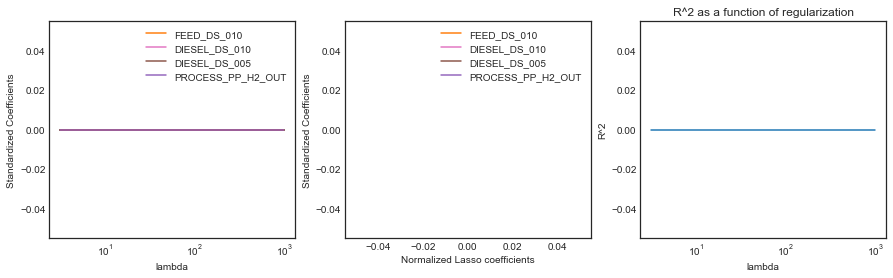

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

# get the four largest (in abs value) coefficient positions
ind = np.argpartition(np.abs(coefs[-1]), -4)[-4:]

# firt plot
ax1.plot(lambdas, coefs)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('Standardized Coefficients')
ax1.legend(np.array(ax1.get_lines())[ind], X.columns[ind])

# second plot
no_lasso_norm = linalg.norm(coefs[-1], ord=1)
norm_coefs = linalg.norm(coefs/no_lasso_norm, axis=1, ord=1)
ax2.plot(norm_coefs, coefs)
ax2.set_xlabel('Normalized Lasso coefficients')
ax2.set_ylabel('Standardized Coefficients')
ax2.legend(np.array(ax2.get_lines())[ind], X.columns[ind]);

# third
ax3.plot(lambdas, scores)
ax3.set_xscale('log')
ax3.set_xlabel('lambda')
ax3.set_ylabel('R^2')
ax3.set_title('R^2 as a function of regularization');

# the values for lambda are different here than in the text
# most likely the function that is minimized is a bit different in scikit-learn and R
# there's probably a factor of N or 2N (N=len(y)) difference.
#https://stats.stackexchange.com/questions/319861/how-to-interpret-lasso-shrinking-all-coefficients-to-0

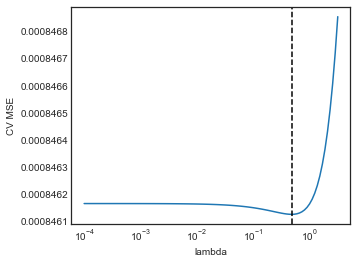

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(lambdas, MSE_alphas)
ax.axvline(ridgeCV.alpha_, color='k', linestyle='--')
ax.set_xscale('log')
ax.set_xlabel('lambda')
ax.set_ylabel('CV MSE');

## Principal Components Regression

In [19]:
components = list(range(1, X_scaled.shape[1]+1))
coefs = []
scores = []
for comp in components:
    pca = PCA(n_components=comp)
    X_pca_comp = pca.fit_transform(X_scaled)
    linear = LinearRegression()
    linear.fit(X_pca_comp, y)
    coefs.append(linear.coef_)
    scores.append(linear.score(X_pca_comp, y))

In [20]:
coefs = np.array(list(itertools.zip_longest(*coefs, fillvalue=0))).T


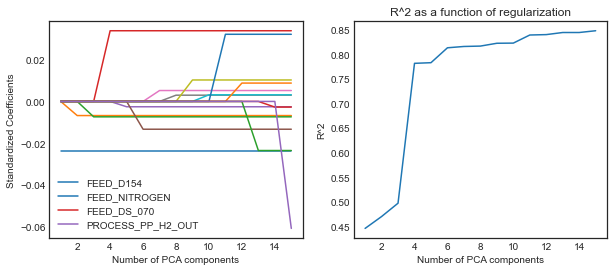

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# get the four largest (in abs value) coefficient positions
ind = np.argpartition(np.abs(coefs[-1]), -4)[-4:]

# firt plot
ax1.plot(components, coefs)
ax1.set_xlabel('Number of PCA components')
ax1.set_ylabel('Standardized Coefficients')
ax1.legend(np.array(ax1.get_lines())[ind], X.columns[ind])

# third
ax2.plot(components, scores)
ax2.set_xlabel('Number of PCA components')
ax2.set_ylabel('R^2')
ax2.set_title('R^2 as a function of regularization');

## Subset Selection Methods

###  Best Subset Selection

In [22]:
# we could also use Exhaustive Feature Selector from mlxtend
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/
def best_subset(estimator, X, y, max_size=8, cv=5):
    n_features = X.shape[1]
    subsets = (combinations(range(n_features), k + 1) for k in range(min(n_features, max_size)))

    best_size_subset = []
    for subsets_k in subsets:  # for each list of subsets of the same size
        best_score = -np.inf
        best_subset = None
        for subset in subsets_k: # for each subset
            estimator.fit(X.iloc[:, list(subset)], y)
            # get the subset with the best score among subsets of the same size
            score = estimator.score(X.iloc[:, list(subset)], y)
            if score > best_score:
                best_score, best_subset = score, subset
        # to compare subsets of different sizes we must use CV
        # first store the best subset of each size
        best_size_subset.append(best_subset)
        
    # compare best subsets of each size
    best_score = -np.inf
    best_subset = None
    list_scores = []
    for subset in best_size_subset:
        score = cross_val_score(estimator, X.iloc[:, list(subset)], y, cv=cv).mean()
        list_scores.append(score)
        if score > best_score:
            best_score, best_subset = score, subset

    return best_subset, best_score, best_size_subset, list_scores

In [23]:
lm = LinearRegression()
best_subset, best_score, best_size_subset, list_scores = best_subset(lm, X, y, max_size=15, cv=5)

In [24]:
for subset, score in zip(best_size_subset,list_scores):
    print(len(subset),' : ',score, X.columns[list(subset)].values)

1  :  0.43674068560989127 ['FEED_D154']
2  :  0.5172990298652177 ['FEED_D154' 'DIESEL_DS_090']
3  :  0.6580508955956208 ['FEED_D154' 'FEED_DS_010' 'DIESEL_DS_030']
4  :  0.6892893471798109 ['FEED_D154' 'FEED_DS_010' 'DIESEL_DS_030' 'FEED_SULFUR']
5  :  0.6418638269634452 ['FEED_D154' 'FEED_DS_010' 'DIESEL_DS_010' 'DIESEL_DS_090' 'FEED_SULFUR']
6  :  0.7050674551831998 ['FEED_D154' 'FEED_DS_090' 'DIESEL_DS_005' 'DIESEL_DS_090' 'FEED_SULFUR'
 'PROCESS_PP_H2_OUT']
7  :  0.717548669734392 ['FEED_D154' 'FEED_DS_090' 'DIESEL_DS_005' 'DIESEL_DS_090' 'FEED_SULFUR'
 'X370PLUS' 'PROCESS_PP_H2_OUT']
8  :  0.7146867166012665 ['FEED_D154' 'FEED_DS_090' 'DIESEL_DS_005' 'DIESEL_DS_090' 'FEED_SULFUR'
 'PROCESS_T_WABT' 'X370PLUS' 'PROCESS_PP_H2_OUT']
9  :  0.7151528431460514 ['FEED_D154' 'FEED_DS_030' 'FEED_DS_090' 'DIESEL_DS_005' 'DIESEL_DS_090'
 'FEED_SULFUR' 'PROCESS_T_WABT' 'X370PLUS' 'PROCESS_PP_H2_OUT']
10  :  0.7100986475173874 ['FEED_D154' 'FEED_DS_010' 'FEED_DS_090' 'DIESEL_DS_005' 'DIESEL_DS_

In [25]:
for subset, score in zip(best_size_subset,list_scores):
    print(len(subset),' : ',score, X.columns[list(subset)].values)

1  :  0.43674068560989127 ['FEED_D154']
2  :  0.5172990298652177 ['FEED_D154' 'DIESEL_DS_090']
3  :  0.6580508955956208 ['FEED_D154' 'FEED_DS_010' 'DIESEL_DS_030']
4  :  0.6892893471798109 ['FEED_D154' 'FEED_DS_010' 'DIESEL_DS_030' 'FEED_SULFUR']
5  :  0.6418638269634452 ['FEED_D154' 'FEED_DS_010' 'DIESEL_DS_010' 'DIESEL_DS_090' 'FEED_SULFUR']
6  :  0.7050674551831998 ['FEED_D154' 'FEED_DS_090' 'DIESEL_DS_005' 'DIESEL_DS_090' 'FEED_SULFUR'
 'PROCESS_PP_H2_OUT']
7  :  0.717548669734392 ['FEED_D154' 'FEED_DS_090' 'DIESEL_DS_005' 'DIESEL_DS_090' 'FEED_SULFUR'
 'X370PLUS' 'PROCESS_PP_H2_OUT']
8  :  0.7146867166012665 ['FEED_D154' 'FEED_DS_090' 'DIESEL_DS_005' 'DIESEL_DS_090' 'FEED_SULFUR'
 'PROCESS_T_WABT' 'X370PLUS' 'PROCESS_PP_H2_OUT']
9  :  0.7151528431460514 ['FEED_D154' 'FEED_DS_030' 'FEED_DS_090' 'DIESEL_DS_005' 'DIESEL_DS_090'
 'FEED_SULFUR' 'PROCESS_T_WABT' 'X370PLUS' 'PROCESS_PP_H2_OUT']
10  :  0.7100986475173874 ['FEED_D154' 'FEED_DS_010' 'FEED_DS_090' 'DIESEL_DS_005' 'DIESEL_DS_

##   Ridge Regression

In [42]:
# alpha = lambda/2
n_lambdas = 100
lambdas = np.logspace(5, -2, n_lambdas)
alphas = lambdas/2

coefs = []
scores = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    coefs.append(ridge.coef_)
    scores.append(mean_squared_error(y_test, ridge.predict(X_test_scaled)))
coefs = np.array(coefs)
scores = np.array(scores)

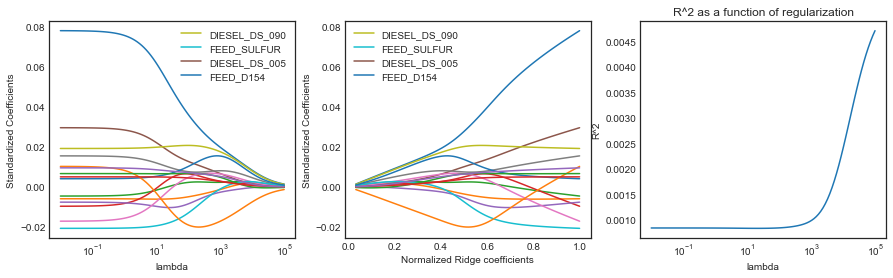

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

ind = np.argpartition(np.abs(coefs[-1]), -4)[-4:]

# firt plot
ax1.plot(lambdas, coefs)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('Standardized Coefficients')
ax1.legend(np.array(ax1.get_lines())[ind], X.columns[ind])

# second plot
no_ridge_norm = linalg.norm(coefs[-1])
norm_coefs = linalg.norm(coefs/no_ridge_norm, axis=1)
ax2.plot(norm_coefs, coefs)
ax2.set_xlabel('Normalized Ridge coefficients')
ax2.set_ylabel('Standardized Coefficients')
ax2.legend(np.array(ax2.get_lines())[ind], X.columns[ind]);

# third
ax3.plot(lambdas, scores)
ax3.set_xscale('log')
ax3.set_xlabel('lambda')
ax3.set_ylabel('R^2')
ax3.set_title('R^2 as a function of regularization');

## Forward and Backward Stepwise Selection

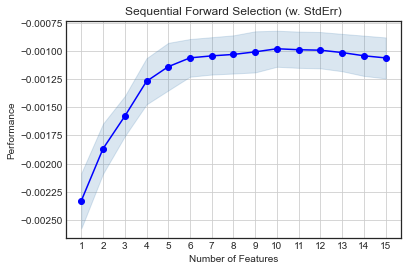


Sequential Forward Selection:
['FEED_D154', 'FEED_DS_030', 'FEED_DS_090', 'DIESEL_DS_005', 'DIESEL_DS_090', 'FEED_SULFUR', 'FEED_NITROGEN', 'PROCESS_T_WABT', 'X370PLUS', 'PROCESS_PP_H2_OUT']
CV Score:
-0.0009803964542258081


In [44]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

lr = LinearRegression()

sfs = SFS(lr, 
          k_features=(1,len(X.columns)), 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

sfs = sfs.fit(X.values, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

print('\nSequential Forward Selection:')
print(X.columns[list(sfs.k_feature_idx_)].tolist())
print('CV Score:')
print(sfs.k_score_)

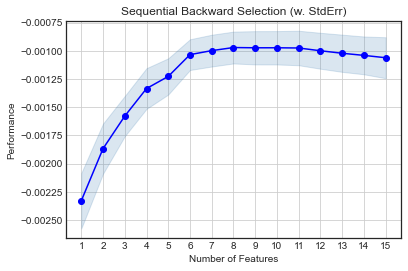


Sequential Backward Selection:
['FEED_D154', 'FEED_DS_070', 'DIESEL_DS_005', 'DIESEL_DS_090', 'FEED_SULFUR', 'PROCESS_T_WABT', 'X370PLUS', 'PROCESS_PP_H2_OUT']
CV Score:
-0.0009713744458399431


In [45]:
lr = LinearRegression()
sbs = SFS(lr, 
          k_features=(1,len(X.columns)), 
          forward=False, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

sbs = sbs.fit(X.values, y)
fig = plot_sfs(sbs.get_metric_dict(), kind='std_err')

plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

print('\nSequential Backward Selection:')
print(X.columns[list(sbs.k_feature_idx_)].tolist())
print('CV Score:')
print(sbs.k_score_)

## Ridge Regression and the Lasso

In [46]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

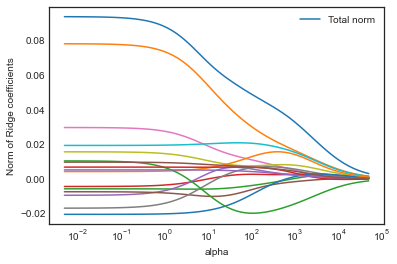

In [48]:
norm_coefs = linalg.norm(coefs, axis=1)
norm_coefs_line = plt.plot(alphas, norm_coefs)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Norm of Ridge coefficients');
plt.legend(norm_coefs_line, ['Total norm']);

In [49]:
idx_4 = find_nearest_idx(lambdas, 4)
idx_10e10 = find_nearest_idx(lambdas, 10e10)

# Ridge with alpha=0 (same as normal LinearRegression)
ridge = Ridge(alpha=0)
ridge.fit(X_train_scaled, y_train)
lr_MSE = mean_squared_error(y_test, ridge.predict(X_test_scaled))

In [50]:
print(f'MSE for intercept-only model: {np.mean(((y_train.mean()-y_test)**2)):f}')
print(f'MSE for lambda = 0:           {lr_MSE:f}')
print(f'MSE for lambda = 4:           {scores[idx_4]:f}')
print(f'MSE for lambda = 10^10:       {scores[idx_10e10]:f}')

MSE for intercept-only model: 0.005390
MSE for lambda = 0:           0.000834
MSE for lambda = 4:           0.000830
MSE for lambda = 10^10:       0.004717


In [51]:
ridgeCV = RidgeCV(alphas=alphas, cv=10, scoring='neg_mean_squared_error')
ridgeCV.fit(X_train_scaled, y_train)
ridgeCV_alpha = ridgeCV.alpha_

In [52]:
ridge = Ridge(alpha=ridgeCV_alpha)
ridge.fit(X_train_scaled, y_train)
ridge_MSE = mean_squared_error(y_test, ridge.predict(X_test_scaled))
print(f'MSE for the best lambda = {ridgeCV_alpha*2:f}: {ridge_MSE:f}')

MSE for the best lambda = 2.535364: 0.000831


In [53]:
# all data
ridge = Ridge(alpha=ridgeCV_alpha)
ridge.fit(X_scaled, y)
# much larger than in the book
pd.Series(np.array((ridge.intercept_, *ridge.coef_)), index=['Intercept', *X.columns])

Intercept            0.735397
FEED_D154            0.066223
FEED_DS_010         -0.004504
FEED_DS_030         -0.003533
FEED_DS_070         -0.002449
FEED_DS_090         -0.009956
DIESEL_DS_005        0.028024
DIESEL_DS_010       -0.014111
DIESEL_DS_030        0.013126
DIESEL_DS_090        0.021471
FEED_SULFUR         -0.020362
FEED_NITROGEN        0.004828
FEED_KWATSON         0.001404
PROCESS_T_WABT       0.006822
X370PLUS             0.005121
PROCESS_PP_H2_OUT    0.008031
dtype: float64

In [54]:
n_alphas = 200
alphas = np.logspace(3, -2, n_alphas)

coefs = []
scores = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)
    scores.append(mean_squared_error(y_test, lasso.predict(X_test_scaled)))

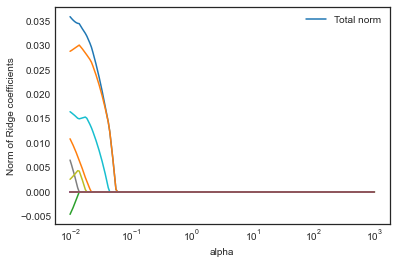

In [55]:
# norm of coefs
norm_coefs = linalg.norm(coefs, axis=1)
norm_coefs_line = plt.plot(alphas, norm_coefs)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Norm of Ridge coefficients');
plt.legend(norm_coefs_line, ['Total norm']);

In [56]:
lassoCV = LassoCV(alphas=alphas, cv=10, max_iter=10000)
lassoCV.fit(X_train_scaled, y_train.values.ravel())
lassoCV_alpha = lassoCV.alpha_

In [57]:
lasso = Lasso(alpha=lassoCV_alpha)
lasso.fit(X_train_scaled, y_train)
lasso_MSE = mean_squared_error(y_test, lasso.predict(X_test_scaled))
print(f'MSE for the best lambda = {lassoCV_alpha*2:f}: {lasso_MSE:f}')

MSE for the best lambda = 0.020000: 0.001320


In [58]:
# all data
lasso = Lasso(alpha=lassoCV_alpha)
lasso.fit(X_scaled, y)
# much larger than in the book
coefs_lasso = pd.Series(np.array((lasso.intercept_, *lasso.coef_)), index=['Intercept', *X.columns])
coefs_lasso = coefs_lasso[coefs_lasso != 0]
coefs_lasso

Intercept        0.735397
FEED_D154        0.027797
DIESEL_DS_010    0.006669
DIESEL_DS_030    0.001791
DIESEL_DS_090    0.018213
FEED_NITROGEN    0.010531
FEED_KWATSON    -0.004577
dtype: float64

## PCR and PLS Regression

##   Principal Components Regression

In [59]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([28.84, 48.06, 66.27, 75.34, 82.7 , 88.9 , 92.36, 95.5 , 97.43,
       98.65, 99.26, 99.63, 99.91, 99.95, 99.99])

In [60]:
components = range(0, X_scaled.shape[1]+1)
scores = []
linear = LinearRegression()

# only intercept
score = -cross_val_score(linear, np.ones((len(y_train), 1)), y_train, cv=10, scoring='neg_mean_squared_error').mean()    
scores.append((score.mean(), score.std()))

for comp in components:
    score = -cross_val_score(linear, X_train_pca[:, 0:comp+1], y_train, cv=10, scoring='neg_mean_squared_error')
    scores.append((score.mean(), score.std()))
scores = np.array(scores)

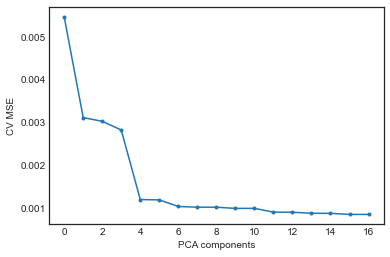

In [61]:
plt.plot(range(0, X_scaled.shape[1]+2), scores[:,0], '.-')
plt.xlabel('PCA components')
plt.ylabel('CV MSE');

In [62]:
X_test_pca = pca.transform(X_test_scaled)

# optimum number of components
opt_comp = scores[:,0].argmin()
linear = LinearRegression()

# fit only the optimum number of components
linear.fit(X_train_pca[:,:opt_comp], y_train)
# get test sample error
pred = linear.predict(X_test_pca[:,:opt_comp])
mean_squared_error(y_test, pred)

0.0008342871440326982

##  Partial Least Squares


In [63]:
components = range(1, X_scaled.shape[1]+1)
scores = []

for comp in components:
    pls = PLSRegression(n_components=comp)
    score = -cross_val_score(pls, X_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error')
    scores.append((score.mean(), score.std()))
scores = np.array(scores)

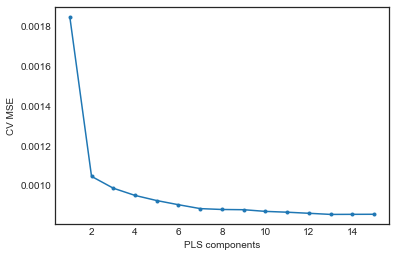

In [64]:
plt.plot(range(1, X_scaled.shape[1]+1), scores[:,0], '.-')
plt.xlabel('PLS components')
plt.ylabel('CV MSE');

In [73]:
# optimum number of components
opt_comp = scores[:,0].argmin()+1
pls = PLSRegression(n_components=opt_comp)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(X_test_scaled))

0.0008304784862687692

# L'hyperparamétrage des plusieurs Algorithmes

In [74]:
from sklearn.model_selection import GridSearchCV

class Model_and_feature_selector:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    
        x=self.score_summary(sort_by='mean_score')
        x.to_csv('scores.csv')

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
                 'scores':np.around(scores, decimals=6),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [75]:
from sklearn import linear_model
from sklearn.linear_model import GammaRegressor,TweedieRegressor,PoissonRegressor
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor ,HuberRegressor
from sklearn.neural_network import MLPRegressor


models  = {
    'GammaRegressor':linear_model.GammaRegressor(),
    'TweedieRegressor': linear_model.TweedieRegressor(),
    'PoissonRegressor': linear_model.PoissonRegressor(),
    'TheilSenRegressor': linear_model.TheilSenRegressor(),
    'RANSACRegressor': linear_model.RANSACRegressor(),
    'HuberRegressor': linear_model.HuberRegressor(),
    'MLPRegressor' : MLPRegressor()
    
    
}

params  = {
    'GammaRegressor':{'alpha':list(np.linspace(0.5, 2, num=4, endpoint=True)),
                           'max_iter': list(range(80,200,20)),
                             'fit_intercept':  [True,False],
                            },
    'TweedieRegressor': { 'power':[0,0.5,3],
                             'alpha':list(np.linspace(0.5, 2, num=4, endpoint=True)),
                             "link":['auto', 'identity','log'],
                            'max_iter': list(range(80,200,20)),
                             'fit_intercept':  [True,False],
                             'tol':[1e-3,1e-4,1e-5,],
                            },
    'PoissonRegressor': {'alpha':list(np.linspace(0.5, 2, num=4, endpoint=True)),
                             'fit_intercept':  [True,False],
                              'max_iter': list(range(80,200,20)),
                                'tol':[1e-3,1e-4,1e-5,],
                             
                              },
    'TheilSenRegressor':  { 'fit_intercept':  [True,False],
                           'copy_X' : [True],
                           'max_iter': list(range(250,500,50)),
                           'max_subpopulation':[1e-3,1e-4,1e-5,],
                           'tol':[1e-3,1e-4,1e-5,],
                           'n_jobs':[-1],
                           },
    'RANSACRegressor': { 'min_samples': [0.2,0.4,0.6,0.8, None],
                                   
                        'max_trials': list(range(80,200,20)),
                                  },
   
    'HuberRegressor': {  
        'epsilon':list(np.linspace(1.01, 2, num=8, endpoint=True)),
        'max_iter': list(range(250,500,50)),
              'fit_intercept':  [True,False],
        'tol':[1e-4,1e-5,1e-6,],
                                  },
        "MLPRegressor": {  
            'learning_rate': ['constant','invscaling','adaptive' ],
                        'activation': ['identity','logistic','tanh','relu'],
                       'solver': ['lbfgs','sgd','adam'],
             'max_iter':range(50,1500,300),
            'tol':[1e-3,1e-4,1e-5,],
            'alpha': [1e-3,1e-4,1e-5,],
            'hidden_layer_sizes':np.arange(4, 11,3)
                                  },
    
}

In [76]:
selector = Model_and_feature_selector(models , params )

In [77]:
# très lent 37 min sur i7 {8 coeurs}.
# selector.fit(X, y, scoring='neg_root_mean_squared_error', n_jobs=-1,cv=10)
# on a sauvegarder son resultat dans 2 fichiers
#'report_comprehensive_refinery_data.csv' 
#'report_compact_refinery_data.csv'

In [78]:
#print("Algorithmes utilisés :")
#report_comprehensive=selector.score_summary(sort_by='mean_score')
#report_compact=report_comprehensive.drop_duplicates(subset= ["estimator"],keep='first').reset_index(drop=True)

In [79]:
#report_comprehensive.to_csv ('report_comprehensive_refinery_data.csv', index=False) 
#report_compact.to_csv ('report_compact_refinery_data.csv', index=False) 

In [80]:
report_comprehensive=pd.read_csv('report_comprehensive_refinery_data.csv')
report_compact=pd.read_csv ('report_compact_refinery_data.csv')              

In [81]:
report_comprehensive.shape

(6708, 22)

In [82]:
report_comprehensive.head(3)

,estimator,min_score,mean_score,max_score,std_score,alpha,fit_intercept,max_iter,scores,link,...,copy_X,max_subpopulation,n_jobs,max_trials,min_samples,epsilon,activation,hidden_layer_sizes,learning_rate,solver
0,MLPRegressor,-0.041364,-0.026636,-0.017763,0.006526,0.00100,NaN,1250.0,[-0.020372 -0.041364 -0.026722 -0.023506 -0.02...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,tanh,4.0,constant,lbfgs
1,MLPRegressor,-0.038650,-0.026710,-0.016543,0.007284,0.00001,NaN,950.0,[-0.019322 -0.03865 -0.023389 -0.038498 -0.02...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,tanh,7.0,constant,lbfgs
2,MLPRegressor,-0.042172,-0.026778,-0.019246,0.006433,0.00001,NaN,950.0,[-0.02201 -0.042172 -0.025334 -0.027706 -0.01...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,logistic,4.0,constant,lbfgs


In [83]:
report_compact.drop(report_compact.tail(1).index,inplace=True) 


In [84]:

report_compact

,estimator,min_score,mean_score,max_score,std_score,alpha,fit_intercept,max_iter,scores,link,...,copy_X,max_subpopulation,n_jobs,max_trials,min_samples,epsilon,activation,hidden_layer_sizes,learning_rate,solver
0,MLPRegressor,-0.041364,-0.026636,-0.017763,0.006526,0.001,NaN,1250.0,[-0.020372 -0.041364 -0.026722 -0.023506 -0.02...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,tanh,4.0,constant,lbfgs
1,HuberRegressor,-0.043132,-0.030829,-0.017117,0.008293,NaN,True,300.0,[-0.022679 -0.043132 -0.035783 -0.030922 -0.02...,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
2,RANSACRegressor,-0.043635,-0.031518,-0.016833,0.008507,NaN,NaN,NaN,[-0.022875 -0.043635 -0.038217 -0.034019 -0.02...,NaN,...,NaN,NaN,NaN,100.0,0.4,NaN,NaN,NaN,NaN,NaN
3,TweedieRegressor,-0.087310,-0.066480,-0.030428,0.017254,0.500,True,80.0,[-0.030428 -0.050838 -0.054197 -0.079851 -0.05...,identity,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GammaRegressor,-0.089949,-0.069316,-0.030527,0.018276,0.500,True,100.0,[-0.030527 -0.051492 -0.055404 -0.084766 -0.06...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PoissonRegressor,-0.090443,-0.069882,-0.030530,0.018484,0.500,True,140.0,[-0.03053 -0.05165 -0.05567 -0.085761 -0.06...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b>C'est la liste des algorithmes en details i.e. leurs listes des scores (1 score pour chaque cross validation), leurs max , min et avg des scores et leurs paramètres.</b>

In [85]:

def get_best(df):
    best={}
    for i in range(len (df)):
        print(i)
        ch,estimator="",''
        r=df.iloc[i]
        r.dropna( inplace=True)
        print((r))
        estimator=r['estimator']
        ch+=estimator+'('
        r=r.drop(['estimator','min_score','mean_score','max_score',
                 'std_score','scores'])
        r=r.to_dict()
        for key in r.keys():
            if str(key) =='kernel' and estimator=='GaussianProcessClassifier':
                ch+=str(key)+'='+str(r[key])+','
            else: 
                if(type(r[key])==str):
                    ch+=str(key)+'="'+str(r[key])+'",'
                elif(int(r[key])==r[key]):
                    ch+=str(key)+'='+str(int(r[key]))+','
                else:
                    ch+=str(key)+'='+str(r[key])+','
        ch=((ch[:-1]+')'))
        best[estimator]=eval(ch)
    return(best)

In [86]:
regs=get_best(report_compact)

0
estimator                                                  MLPRegressor
min_score                                                    -0.0413644
mean_score                                                   -0.0266356
max_score                                                    -0.0177631
std_score                                                    0.00652574
alpha                                                             0.001
max_iter                                                           1250
scores                [-0.020372 -0.041364 -0.026722 -0.023506 -0.02...
tol                                                               1e-05
activation                                                         tanh
hidden_layer_sizes                                                    4
learning_rate                                                  constant
solver                                                            lbfgs
Name: 0, dtype: object
1
estimator                            

<ipython-input-85-58e335faf211>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<b>C'est une fonction qui affiche chaque model avec ses details et retourne un dictionnaire contenant les models paramétrès préts à l'execution (i.e. pour une automatisation ou un pipeline) </b>

In [87]:
regs

{'MLPRegressor': MLPRegressor(activation='tanh', alpha=0.001, hidden_layer_sizes=4,
              max_iter=1250, solver='lbfgs', tol=1e-05),
 'HuberRegressor': HuberRegressor(epsilon=2, fit_intercept=1, max_iter=300, tol=1e-06),
 'RANSACRegressor': RANSACRegressor(min_samples=0.4),
 'TweedieRegressor': TweedieRegressor(alpha=0.5, fit_intercept=1, link='identity', max_iter=80,
                  power=3, tol=0.001),
 'GammaRegressor': GammaRegressor(alpha=0.5, fit_intercept=1),
 'PoissonRegressor': PoissonRegressor(alpha=0.5, fit_intercept=1, max_iter=140)}